### Part 1. Data Acquisition & Preprocessing
#### Staring with incorperating the dataset

In [1]:
%pip install kaggle -q

Note: you may need to restart the kernel to use updated packages.


In [73]:
# Importing all neccessary frameworks

import numpy as np
import torch


from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import normalize, scale, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

#%load_ext cudf.pandas
import pandas as pd

#if RAPIDS packages are installed
from cuml.manifold import UMAP
from cuml.cluster import hdbscan

#otherwise
#import umap.umap_ as umap
#import hdbscan

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Downloading the dataset from Kaggle
#python .env use
from dotenv import load_dotenv

load_dotenv()

!kaggle datasets download -d elvinrustam/books-dataset --unzip --force

Dataset URL: https://www.kaggle.com/datasets/elvinrustam/books-dataset
License(s): CC0-1.0
 98%|█████████████████████████████████████▎| 52.0M/52.9M [00:00<00:00, 76.0MB/s]
100%|██████████████████████████████████████| 52.9M/52.9M [00:00<00:00, 62.9MB/s]


# Preproccessing Data Steps.

**Data Sources**

From Kaggle, we were able to use a Book Dataset with over 100,000 observations. It includes multiple features such as authors, genres, titles, & date of publication.

In [10]:
# Extracting the info from the CSV field
gb_md = pd.read_csv('./BooksDatasetClean.csv')

In [11]:
# Here we are printing the original data from the csv
gb_md

,Title,Authors,Description,Category,Publisher,Price Starting With ($),Publish Date (Month),Publish Date (Year)
0,Goat Brothers,"By Colton, Larry",NaN,"History , General",Doubleday,8.79,January,1993
1,The Missing Person,"By Grumbach, Doris",NaN,"Fiction , General",Putnam Pub Group,4.99,March,1981
2,Don't Eat Your Heart Out Cookbook,"By Piscatella, Joseph C.",NaN,"Cooking , Reference",Workman Pub Co,4.99,September,1983
3,When Your Corporate Umbrella Begins to Leak: A...,"By Davis, Paul D.",NaN,NaN,Natl Pr Books,4.99,April,1991
4,Amy Spangler's Breastfeeding : A Parent's Guide,"By Spangler, Amy",NaN,NaN,Amy Spangler,5.32,February,1997
...,...,...,...,...,...,...,...,...
103058,Build 3 Super Serving Carts,By Chuck Hampton,NaN,NaN,ENDesigns Inc.,9.97,January,1992
103059,My Land of Israel,"By Nover, Elizabeth Z.",NaN,"Juvenile Nonfiction , People & Places , Middl...",Behrman House,4.99,May,1987
103060,Tongues: To Speak or Not to Speak,By Donald W. Burdick,NaN,NaN,Moody Press,5.29,January,1969
103061,If I'm in charge here why is everybody laughing?,"By Campbell, David P.",NaN,NaN,Argus Communications,4.99,January,1980


**Data Cleaning and Preprocessing**

In this step, we will remove any noisy data with inconsistencies and missing values. Then, we will modify our data by applying tokenization techniques.

In [ ]:
# Dropping all observations with missing values
gb_md = gb_md.dropna()

# Now we will be dropping features that are irrelevant for us
gb_md = gb_md.drop(columns=['Price Starting With ($)', 'Publisher', 'Publish Date (Month)'])


In [14]:
# Removing the value 'General' from the 'Categories' feature in order to avoid bad clusterings
gb_md['Category'] = gb_md['Category'].str.replace('General', '', regex=False)
gb_md['Category'] = gb_md['Category'].str.strip()
gb_md = gb_md[gb_md['Category'] != '']
gb_md['Category'] = gb_md['Category'].str.rstrip(',')

# Removing "By" in the Authors Column
gb_md['Authors'] = gb_md['Authors'].str.replace('^By ', '', regex=True)

#Removing Duplicate Titles
gb_md.drop_duplicates(subset=["Title"], keep="first", inplace=True)


In [15]:
# Demonstrating the first five observations of our "clean" data
gb_md.head()

,Title,Authors,Description,Category,Publish Date (Month),Publish Date (Year)
7,Journey Through Heartsongs,"Stepanek, Mattie J. T.",Collects poems written by the eleven-year-old ...,Poetry,September,2001
8,In Search of Melancholy Baby,"Aksyonov, Vassily, Heim, Michael Henry, and Bo...",The Russian author offers an affectionate chro...,Biography & Autobiography,June,1987
10,The Dieter's Guide to Weight Loss During Sex,"Smith, Richard","A humor classic, this tongue-in-cheek diet pla...","Health & Fitness , Diet & Nutrition , Diets",January,1978
11,Germs : Biological Weapons and America's Secre...,"Miller, Judith, Engelberg, Stephen, and Broad,...","Deadly germs sprayed in shopping malls, bomb-l...","Technology & Engineering , Military Science",October,2001
13,The Good Book: Reading the Bible with Mind and...,"Gomes, Peter J.","""The Bible and the social and moral consequenc...","Religion , Biblical Biography",May,1998


In [16]:
df = gb_md

In [17]:
df.head()

,Title,Authors,Description,Category,Publish Date (Month),Publish Date (Year)
7,Journey Through Heartsongs,"Stepanek, Mattie J. T.",Collects poems written by the eleven-year-old ...,Poetry,September,2001
8,In Search of Melancholy Baby,"Aksyonov, Vassily, Heim, Michael Henry, and Bo...",The Russian author offers an affectionate chro...,Biography & Autobiography,June,1987
10,The Dieter's Guide to Weight Loss During Sex,"Smith, Richard","A humor classic, this tongue-in-cheek diet pla...","Health & Fitness , Diet & Nutrition , Diets",January,1978
11,Germs : Biological Weapons and America's Secre...,"Miller, Judith, Engelberg, Stephen, and Broad,...","Deadly germs sprayed in shopping malls, bomb-l...","Technology & Engineering , Military Science",October,2001
13,The Good Book: Reading the Bible with Mind and...,"Gomes, Peter J.","""The Bible and the social and moral consequenc...","Religion , Biblical Biography",May,1998


In [18]:
#Combining the columns description + category which should capture semantics of genre and their summaries
text_data = df['Title']+ ': ' + df['Description'] + ": " + df['Category']

# Initializing our tokenizer from the transformers model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
# Also initializing our pre-trained LLM --> BERT
book_model = AutoModel.from_pretrained("bert-base-uncased")

In [19]:
print(torch.cuda.is_available())

True


In [20]:
book_model = book_model.to('cuda')

def get_embeddings_for_chunk(chunk):
    tokenized_inputs = tokenizer(
        chunk,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=512  # Ensure truncation for long texts
    ).to('cuda')  # Move to GPU
    outputs = book_model(**tokenized_inputs)
    hidden_states = outputs.last_hidden_state  # Shape: (batch_size, seq_len, hidden_dim)
    embeddings = hidden_states.mean(dim=1)  # Mean pooling across tokens
    return embeddings.detach().cpu().numpy()  # Move to CPU before converting to numpy


In [21]:
# Define batch size
batch_size = 24  # Adjust based on available memory

# Process dataset in chunks to avoid memory overload
num_chunks = len(df) // batch_size + 1  # Total chunks based on batch size
all_embeddings = []
for i in range(num_chunks):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(df))

    # Retry mechanism for out-of-memory
    while True:
        try:
            chunk = text_data[start_idx:end_idx].tolist()
            embeddings_chunk = get_embeddings_for_chunk(chunk)
            if i % 10 == 0 or num_chunks - i < 10:
                print(f'Chunk {i} of {num_chunks}') 
            break
        except RuntimeError as e:
            if "out of memory" in str(e):
                batch_size //= 2  # Halve the batch size
                torch.cuda.empty_cache()  # Clear GPU memory
            else:
                raise e
    all_embeddings.append(embeddings_chunk)
    


# Combine all chunks into a single list of embeddings
all_embeddings = np.vstack(all_embeddings)


Chunk 0 of 2587
Chunk 10 of 2587
Chunk 20 of 2587
Chunk 30 of 2587
Chunk 40 of 2587
Chunk 50 of 2587
Chunk 60 of 2587
Chunk 70 of 2587
Chunk 80 of 2587
Chunk 90 of 2587
Chunk 100 of 2587
Chunk 110 of 2587
Chunk 120 of 2587
Chunk 130 of 2587
Chunk 140 of 2587
Chunk 150 of 2587
Chunk 160 of 2587
Chunk 170 of 2587
Chunk 180 of 2587
Chunk 190 of 2587
Chunk 200 of 2587
Chunk 210 of 2587
Chunk 220 of 2587
Chunk 230 of 2587
Chunk 240 of 2587
Chunk 250 of 2587
Chunk 260 of 2587
Chunk 270 of 2587
Chunk 280 of 2587
Chunk 290 of 2587
Chunk 300 of 2587
Chunk 310 of 2587
Chunk 320 of 2587
Chunk 330 of 2587
Chunk 340 of 2587
Chunk 350 of 2587
Chunk 360 of 2587
Chunk 370 of 2587
Chunk 380 of 2587
Chunk 390 of 2587
Chunk 400 of 2587
Chunk 410 of 2587
Chunk 420 of 2587
Chunk 430 of 2587
Chunk 440 of 2587
Chunk 450 of 2587
Chunk 460 of 2587
Chunk 470 of 2587
Chunk 480 of 2587
Chunk 490 of 2587
Chunk 500 of 2587
Chunk 510 of 2587
Chunk 520 of 2587
Chunk 530 of 2587
Chunk 540 of 2587
Chunk 550 of 2587
Chu

In [22]:
# Normalize the embeddings to ensure consistent similarity scores
normalized_embeddings = normalize(all_embeddings)
#standardized_embeddings = StandardScaler().fit_transform(all_embeddings)
#minMax_embeddings = MinMaxScaler().fit_transform(all_embeddings)

current_embeddings = normalized_embeddings
current_scaler = normalize
current_name = "normalize"

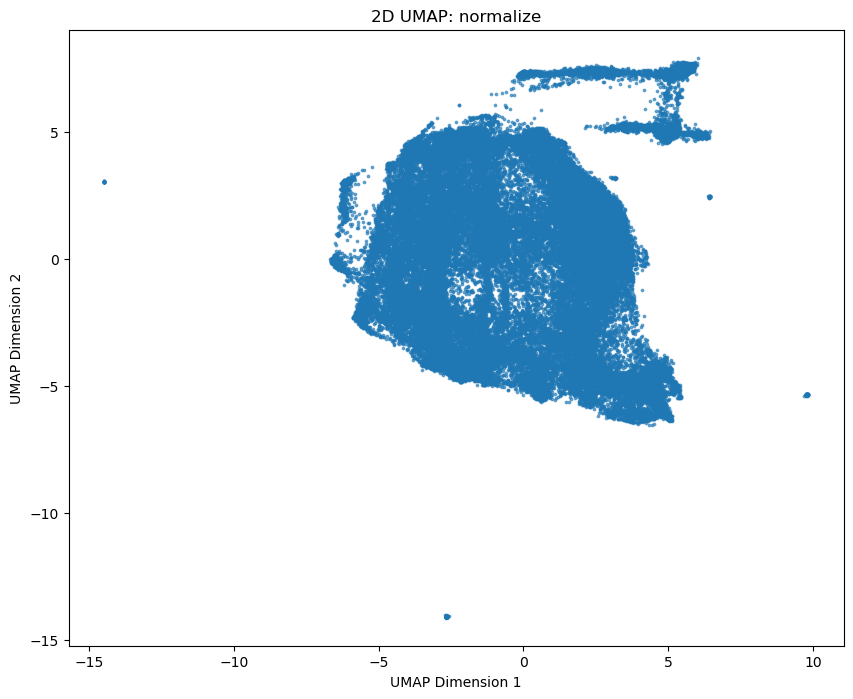

In [71]:
#Implement UMAP

def umapTest(data, name=None, neighbors=45, display=True):
    dim_reducer = UMAP(n_neighbors=neighbors, n_components=2, random_state=42)

    embed_UMAP = dim_reducer.fit_transform(data)
    if display:
        plt.figure(figsize=(10,8))
        plt.scatter(embed_UMAP[:, 0], embed_UMAP[:, 1], cmap='Spectral', s=3, alpha=0.6)
        plt.title(f'2D UMAP: {name}' if name else '2D UMAP')
        plt.xlabel("UMAP Dimension 1")
        plt.ylabel("UMAP Dimension 2")
        plt.show()
    return embed_UMAP

embed_U = umapTest(current_embeddings, current_name)

In [72]:
hdb = hdbscan.HDBSCAN()
embed_hdb = hdb.fit_predict(embed_U)

print(f"Number of clusters found: {len(set(embed_hdb))}")
print(f"Number of noise points: {sum(embed_hdb == -1)}")

Number of clusters found: 2111
Number of noise points: 27294


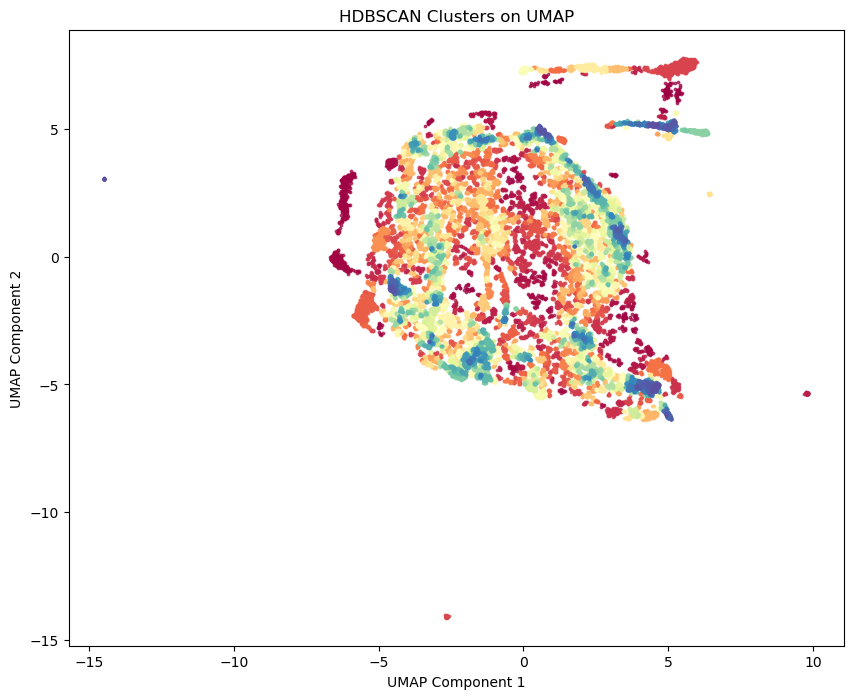

In [74]:
plt.figure(figsize=(10, 8))
unique = np.unique(embed_hdb)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique)))
for k, color in zip(unique, colors):
    mask = (embed_hdb == k)
    if k != -1:  # Exclude noise
        plt.scatter(
            embed_U[mask, 0],
            embed_U[mask, 1],
            c=[color], 
            label=f'Cluster {k}', 
            s=3, 
            alpha=0.7
    )


#plt.legend(loc='upper right', markerscale=5, fontsize='small', title='Clusters')
plt.title("HDBSCAN Clusters on UMAP")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()

In [75]:

# Get the user's favorite book and genre
#fav_book = input('Enter your favorite book name: ')  # Example: "Rage of Angels"
#fav_genre = input('What is your favorite genre: ')  # Example: "Thriller"


def user_input(book, genre):
    # Combine the favorite book and genre to form a user input
    usr_input = book + ": " + genre


    # Tokenize user input and generate embedding
    tokenized_input = tokenizer(
        usr_input,
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to('cuda')
    return tokenized_input

#user_tokens = user_input(fav_book, fav_genre)

In [76]:
def get_answer(tokens):
    user_embedding = book_model(**tokens)
    hidden_states = user_embedding.last_hidden_state  # Shape: (batch_size, seq_len, hidden_dim)
    usr_embeddings = hidden_states.mean(dim=1)  # Mean pooling across tokens
    ue = usr_embeddings.detach().cpu().numpy()
    norm_ue = np.vstack(ue)

    norm_ue = normalize(norm_ue)

    # Calculate cosine similarity between the user's input embedding and all book embeddings
    similarity_scores = cosine_similarity(norm_ue, current_embeddings).flatten()

    # Get the top 5 most similar books
    # top_indices = similarity_scores.argsort()[-5:][::-1]  # Indices of the top 5 books
    df["Similarity"] = similarity_scores.T

In [100]:
def get_scores(data, selection, genre):
    total_rec = selection[selection['Category'].str.contains(genre)]
    total_genre = data[data['Category'].str.contains(genre)]
    if (total_rec.size*total_genre.size == 0):
        print(f'No exact match for {genre}')
        return [0,0,0,0]
    precision = (len(total_rec) / len(selection))
    recall = (len(total_rec) / len(total_genre))
    f1_score = (2*((precision*recall) / (precision + recall)))
    top_result = data[data['Category'].str.contains(genre)].iloc[0]
    for i in range(len(data)):
        if data.iloc[i]['Title'] == top_result['Title']:
            mrr = (1 / i+1) / len(selection)
            return [precision, recall, f1_score, mrr]
    mrr = (1 / len(data)) / len(selection)
    return [precision, recall, f1_score, mrr]

In [101]:
def llm_routine():
    book = input('Enter your favorite book name: ')  # Example: "Rage of Angels"
    genre = input('What is your favorite genre: ')  # Example: "Thriller"
    print(f'Book: {book}, Genre: {genre}')
    get_answer(user_input(book, genre))
    print('Recommended')
    recommended_book_val = df['Similarity'].max()
    above_threshold = df[recommended_book_val - df['Similarity'] > 0.08]
    recommended_books = df.drop(above_threshold.index).sort_values(by="Similarity", ascending=False).head(10)
    print(f'Total Number of Results: {len(recommended_books)}')
    if (df.size*recommended_books.size == 0):
        print(f'No Recommendations available for {book} and {genre}')
    else:
        display(recommended_books[["Title", "Category", "Similarity"]].head(10))
        return get_scores(df, recommended_books, genre)
 

In [102]:
def test_routine():
    p_sum = []

    for i in range(4):
        print(f'Trial {i+1}')
        values = llm_routine()
        print(f'Precision: {values[0]:.4f}, '
          f'\nRecall: {values[1]:.4f}, '
          f'\nF1 Score: {values[2]:.4f}'
          f'\nMRR: {values[3]:.4f}')
        p_sum.append(values[0])
        print()
        
    print(f'\nMAP: {(sum(p_sum) / len(p_sum)):.4f}')

test_routine()

Trial 1
Book: Laws of Physics, Genre: Science
Recommended
Total Number of Results: 10


,Title,Category,Similarity
30856,The Mind of God: The Scientific Basis for a Ra...,Science,0.606955
37766,Schaum's Outline of Theory and Problems of Phy...,Science,0.603106
62790,Quantum Theory (Dover Books on Physics),"Science , Physics",0.588918
57547,Sidelights on Relativity,"Mathematics , Geometry",0.581750
96965,Matrices and Linear Transformations: Second Ed...,"Mathematics , Matrices",0.580793
61373,Understanding Einstein's Theories of Relativit...,"Mathematics , Geometry , Non-Euclidean",0.580763
1637,The Periodic Kingdom: A Journey Into The Land ...,"Science , Chemistry",0.579133
47050,Introduction to Probability (Dover Books on Ma...,"Mathematics , Probability & Statistics",0.578243
37072,Algebra & Trigonometry I Essentials (Volume 1)...,"Mathematics , Trigonometry",0.577216
66330,"The Little Book of Scientific Principles, Theo...","Science , History",0.575624


Precision: 0.5000, 
Recall: 0.0009, 
F1 Score: 0.0019
MRR: 0.1333

Trial 2
Book: Art in the Renaissance Period, Genre: History
Recommended
Total Number of Results: 10


,Title,Category,Similarity
54905,Italy: A Short History,"History , Europe , Italy",0.689154
98048,Skira Dictionary of Modern Decorative Arts,Antiques & Collectibles,0.684998
68218,Costume and Fashion: A Concise History (World ...,"Design , Fashion & Accessories",0.682627
26917,The Civilization of Europe in the Renaissance,"History , Europe",0.681077
93995,Maps and History: Constructing Images of the Past,"History , Historiography",0.678684
53506,The Oxford History of the Classical World: Gre...,"History , Ancient , Rome",0.673603
14115,Movements in art since 1945 (World of art),"Art , History , Modern (late 19th Century to 1...",0.670357
97810,"Il Gigante: Michelangelo, Florence, and the Da...","Art , Individual Artists",0.668879
598,What Went Wrong?: Western Impact and Middle Ea...,"History , Middle East",0.664522
51575,The Two Cities: Medieval Europe 1050–1320,"History , Europe",0.663850


Precision: 0.7000, 
Recall: 0.0026, 
F1 Score: 0.0052
MRR: 0.1100

Trial 3
Book: Iron Man', Genre: Science Fiction
Recommended
Total Number of Results: 10


,Title,Category,Similarity
39257,"Fantastic Four, Vol. 1: All for One","Juvenile Fiction , Comics & Graphic Novels , S...",0.651832
93205,Killer Of Demons,"Comics & Graphic Novels , Fantasy",0.643429
84446,Ares Express,"Fiction , Science Fiction",0.639892
78649,Billboards,"Comics & Graphic Novels , Science Fiction",0.632877
46129,The Graveyard Game,"Fiction , Science Fiction , Action & Adventure",0.629811
39151,Death's Head 3.0: Unnatural Selection,"Comics & Graphic Novels , Superheroes",0.629404
39147,Half Dead,"Comics & Graphic Novels , Horror",0.625415
84478,Anakin in Action! (Star Wars: The Clone Wars),"Juvenile Fiction , Science Fiction",0.624206
39105,Spider-Man: Saga of the Sandman,"Young Adult Fiction , Comics & Graphic Novels ...",0.624155
94605,I Am Number Four Movie Tie-in Edition (Lorien ...,"Young Adult Fiction , Science Fiction",0.623679


Precision: 0.5000, 
Recall: 0.0057, 
F1 Score: 0.0112
MRR: 0.1009

Trial 4
Book: Thor, Genre: Comics
Recommended
Total Number of Results: 10


,Title,Category,Similarity
39257,"Fantastic Four, Vol. 1: All for One","Juvenile Fiction , Comics & Graphic Novels , S...",0.546526
39105,Spider-Man: Saga of the Sandman,"Young Adult Fiction , Comics & Graphic Novels ...",0.544944
27199,"Like Father, Like Daughter (Spider-Girl, Vol. 2)","Juvenile Fiction , Comics & Graphic Novels , S...",0.533574
79694,Kaboom! Volume 1,"Comics & Graphic Novels , Superheroes",0.530102
60922,Death of Superman (Superman (DC Comics)),"Comics & Graphic Novels , Superheroes",0.526255
39110,Ultimate Annuals Volume 2,"Comics & Graphic Novels , Superheroes",0.525905
39123,Civil War: Heroes For Hire,"Comics & Graphic Novels , Superheroes",0.524684
87734,Iron Man: I Am Iron Man!,"Comics & Graphic Novels , Superheroes",0.523999
39124,Fantastic Four Vol. 6: Rising Storm,"Young Adult Fiction , Comics & Graphic Novels ...",0.523171
93205,Killer Of Demons,"Comics & Graphic Novels , Fantasy",0.516420


Precision: 1.0000, 
Recall: 0.0581, 
F1 Score: 0.1099
MRR: 0.1003


MAP: 0.6750
